TP2: Visión por computadora I (22Co2025)

Integrantes:

    Barniquez Piñero, Alexis Geraldine
    Paniagua, Daniel Gerardo
    Salamone Castro, Brian Adriano


# Enunciado

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en  
`Material_TPs/TP3/images` a partir del template `Material_TPs/TP3/template`
1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.
Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

# Preparación

In [1]:
import os

TP3_DIR = os.getcwd()
TEMPLATE_PATH = f"{TP3_DIR}/template/pattern.png"
IMG_DIR = f"{TP3_DIR}/images"

## Carga de la imagen template

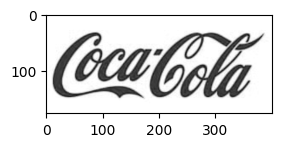

In [2]:
import matplotlib.pyplot as plt
import cv2 as cv

template = cv.imread(TEMPLATE_PATH,0)
template_gray = cv.cvtColor(template, cv.COLOR_BAYER_BG2GRAY)

w, h = template.shape[::-1]

plt.figure()
plt.subplot(1,2,1)
plt.imshow(template, cmap='gray')

## Transformaciones del template

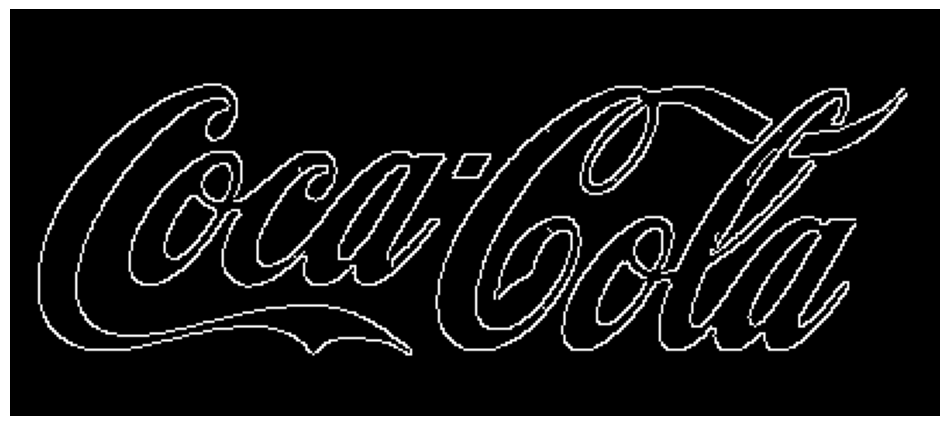

In [3]:
import supervision as sv

template_edges = cv.Canny(template, threshold1=5, threshold2=200)
sv.plot_image(template_edges)

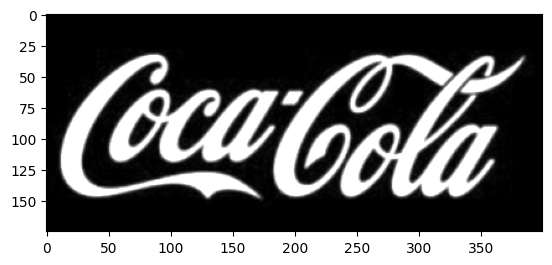

In [4]:

template_brillo = cv.bitwise_not(template_gray)
template_brillo=cv.convertScaleAbs(template_brillo, alpha=1.0, beta=150)

plt.imshow(template_brillo, cmap='gray')

## Función de carga de las imagenes a procesar

In [5]:
def cargar_imagenes_desde_carpeta(folder):
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            yield img, filename

# Resolución punto 1

Para el reconocimiento de imágenes con características muy variadas, conviene utilizar algoritmos de extracción de características complejos. Para este ejercicio se decidió limpiar un poco el template mediante inversión de color y aumento de brillo y realizar una búsqueda de descriptores mediante SIFT. Posteriormente se procederá a coincidir los descriptores hallados mediante FLANN, que es una técnica que utiliza KNN. Se utiliza también homografía para encontrar la transformación aproximada que toma el parche dentro de la imagen.

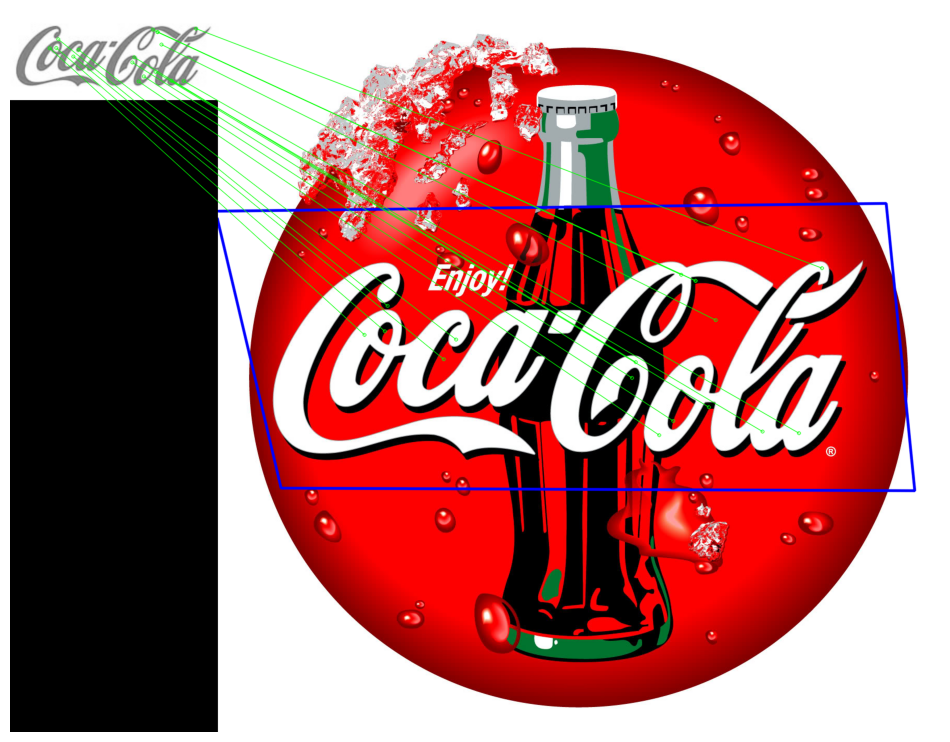

No se encontraron suficientes coincidencias - 4/8


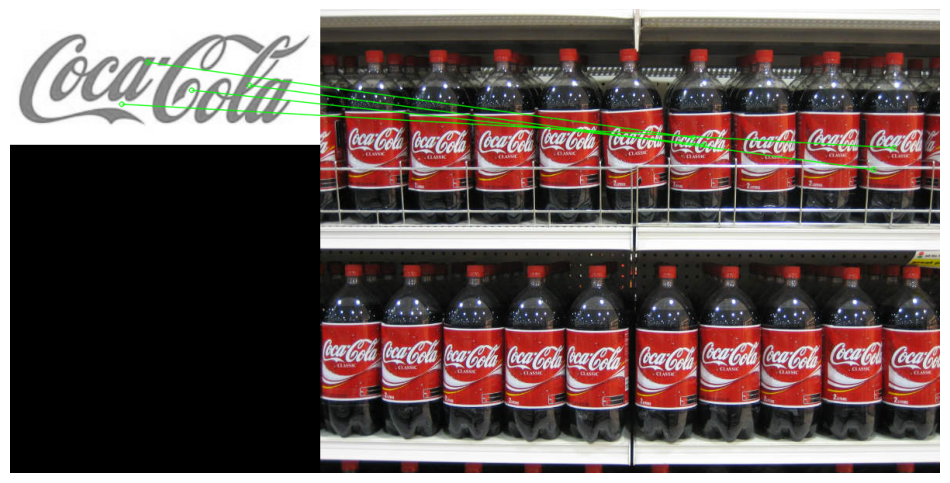

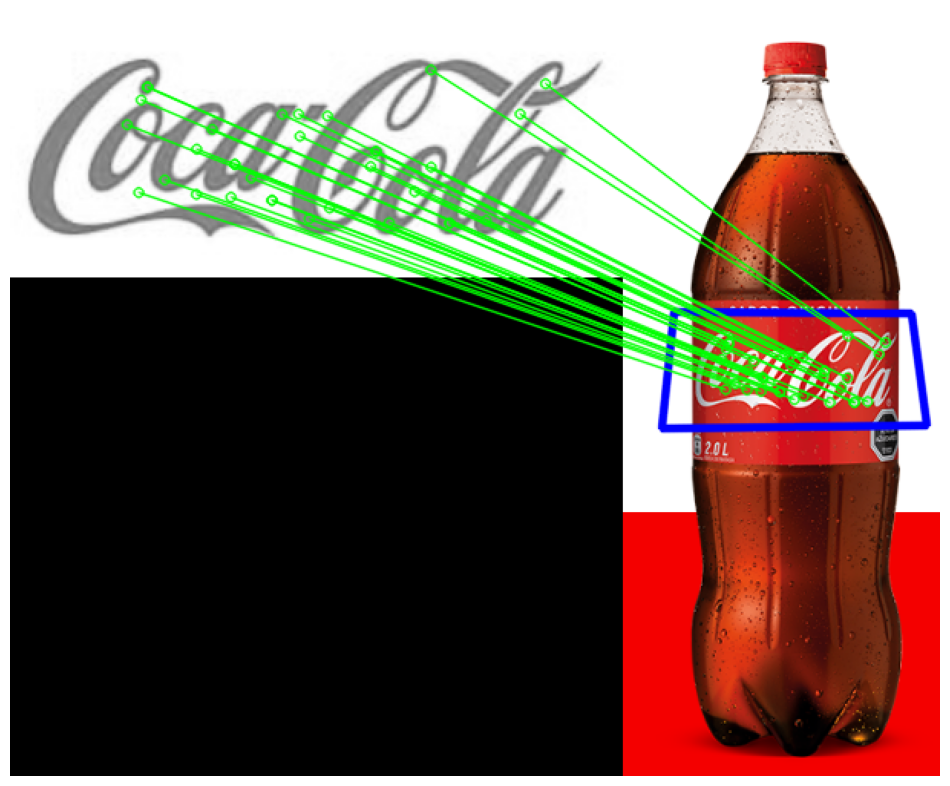

No se encontraron suficientes coincidencias - 3/8


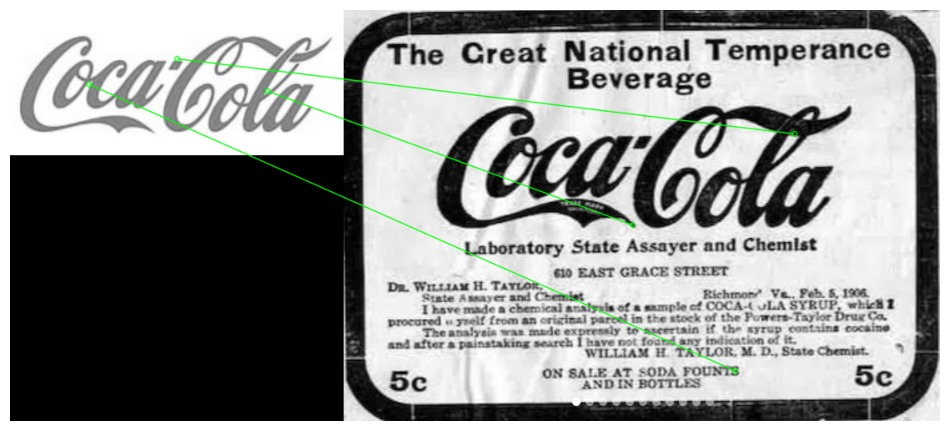

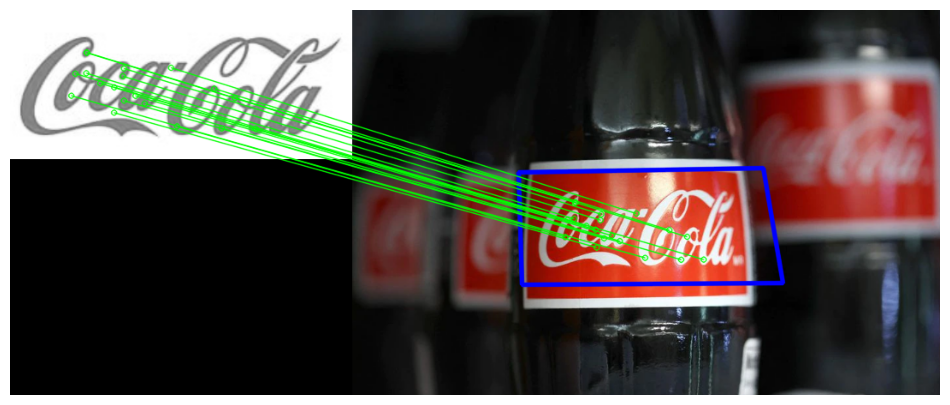

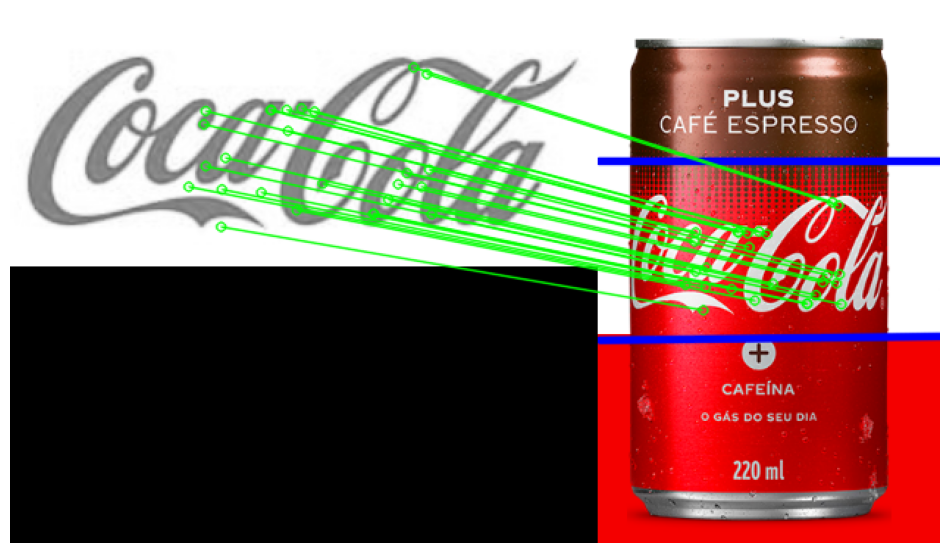

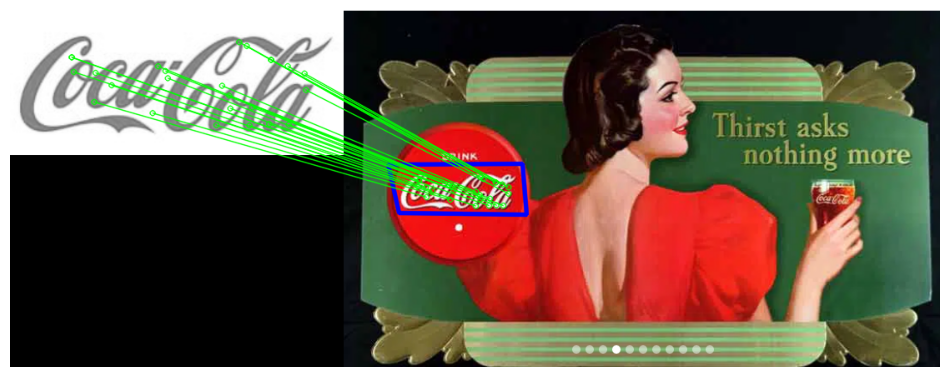

In [6]:
import numpy as np

# Encaramos la solución con SIFT + FLANN + HOMOGRAFIA
sift = cv.SIFT_create()

# Busco descriptores en template, inicializo matcher
kp1, des1 = sift.detectAndCompute(template_brillo,None)

bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

for img, filename in cargar_imagenes_desde_carpeta(IMG_DIR):
    
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Busco descriptores en las imágenes
    kp2, des2 = sift.detectAndCompute(img_gray,None)

    # Preparo los parámetros para el uso de FLANN para matchear descriptores
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # Guardar todos las buenas coincidencias según la verificación de Ratio de Lowe
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)


    # Homografía. Encuentro coincidencias para trazar un paralelismo geométrico
    MIN_MATCH_COUNT = 8

    if len(good) >= MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
        h,w = template.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts, M)
        img = cv.polylines(img, [np.int32(dst)], True, 255, 3, cv.LINE_AA)
    else:
        print( "No se encontraron suficientes coincidencias - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None


    # Dibujamos
    draw_params = dict(matchColor = (0,255,0),
                    singlePointColor = None,
                    matchesMask = matchesMask,
                    flags = 2)
    img3 = cv.drawMatches(template, kp1, img, kp2, good, None, **draw_params)
    sv.plot_image(img3)

# Resolución punto 2

Para este ejercicio se decidió utilizar template matching. Para tal fin se aplicaron los siguientes filtros sobre el parche y sobre la imagen:
- Difference of Gaussian: Técnica para resaltar bordes. Tuvo impacto sobre los resultados, pero no tanto como el siguiente filtro,
- Canny: Obtención de imagen de bordes.

Utilizando solo ese algoritmo en ambas partes se logró empezar a detectar las etiquetas.

Debido a la presencia de parches blancos y negros en el fondo de la imagen, el método elegido para template matching fue TM_COEFF, que es robusto en estos escenarios.

Para la escala, se experimentó hasta dar con la correcta.

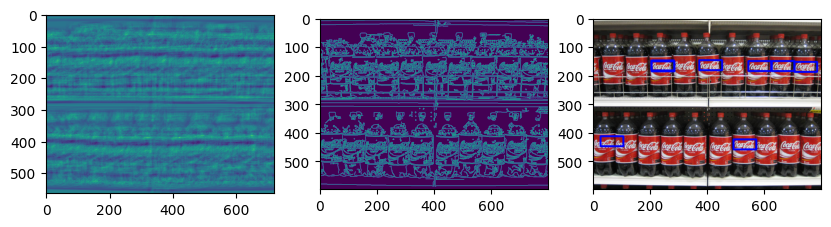

In [7]:
temp = template_edges.copy()

# Rescalamos porque template matching no es invariante a escala
scale=.2
temp = cv.resize(temp, None, fx=scale, fy=scale)
w, h = temp.shape[::-1]

# Leemos la imagen
img = cv.imread(os.path.join(IMG_DIR,'coca_multi.png'))
*_, img_w, img_h = img.shape[::-1]

# Pasamos a escala de grises y calculamos bordes
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_gray = cv.Canny(img_gray, threshold1=5, threshold2=200)

# Matcheamos
res = cv.matchTemplate(img_gray, temp, cv.TM_CCOEFF)

# Filtramos por cierto umbral para obtener más que un resultado
threshold = np.max(res)*(.75)
loc = np.where(res >= threshold)

# Dibujamos los rectángulos
for top_left in zip(*loc[::-1]):
  bottom_right = (top_left[0] + w, top_left[1] + h)
  rect_width = int(img_w* img_h ** .5) // 3000
  cv.rectangle(img_rgb, top_left, bottom_right, (0, 0, 255), rect_width)


# Graficamos
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(res)

plt.subplot(1, 3, 2)
plt.imshow(img_gray)

plt.subplot(1, 3, 3)
plt.imshow(img_rgb)


# Resolución punto 3

Para este problema se utilizó gran parte del código del punto 2. En esta ocasión, se incluyó también un seleccionador de escalas, ya que este desafío cuenta con más incertidumbre en las entradas, y template matching no es invariante a escala.

Para solucionarlo se utilizó rescalado arbitrario. La escala se decidió en 10 escalones pero multiplicado por un tercio del ratio entre la imagen objetivo y el parche. De esta manera nos aproximamos más rápidamente a la escala correcta.

Para seleccionar la escala correcta se maximizó el puntaje que arrojó `matchTemplate` en cada escala probada y se guardó el mejor puntaje y la escala que logró dicho puntaje.

Imagen:  COCA-COLA-LOGO.jpg


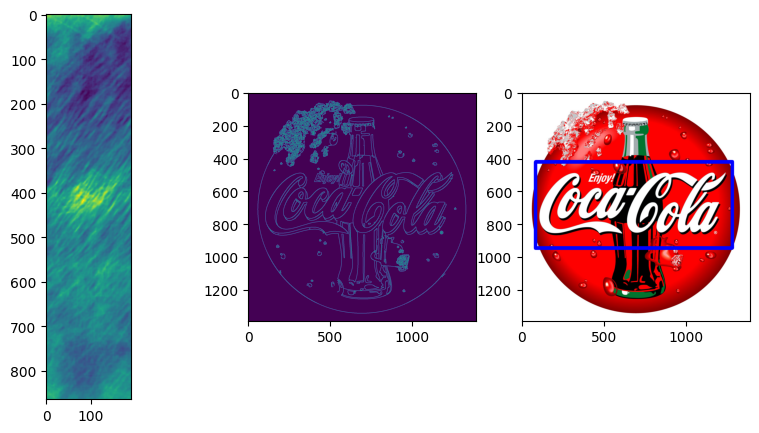

Imagen:  coca_multi.png


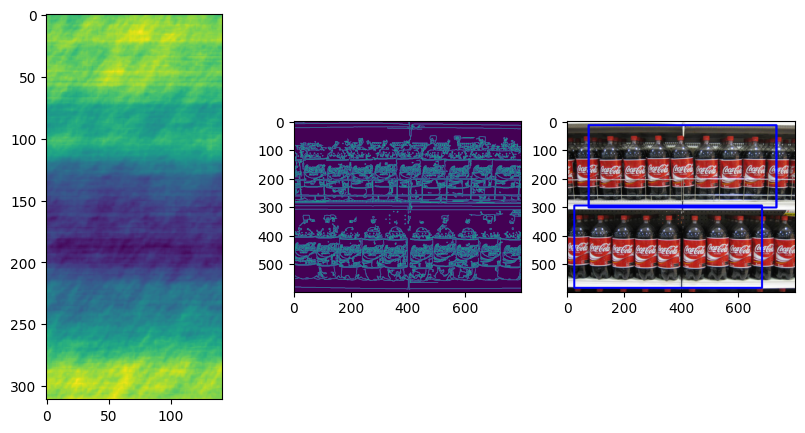

Imagen:  coca_logo_1.png


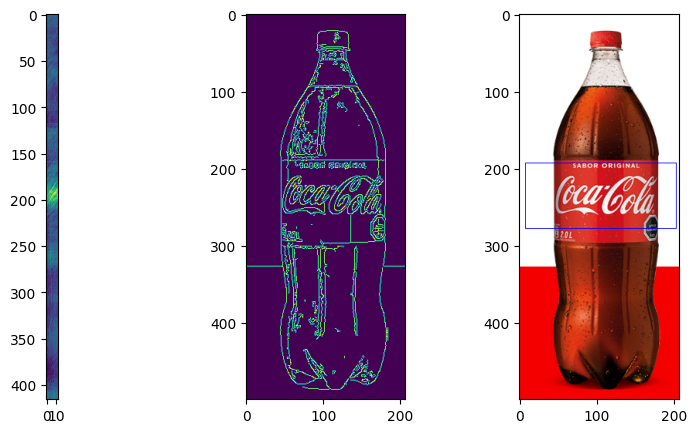

Imagen:  coca_retro_1.png


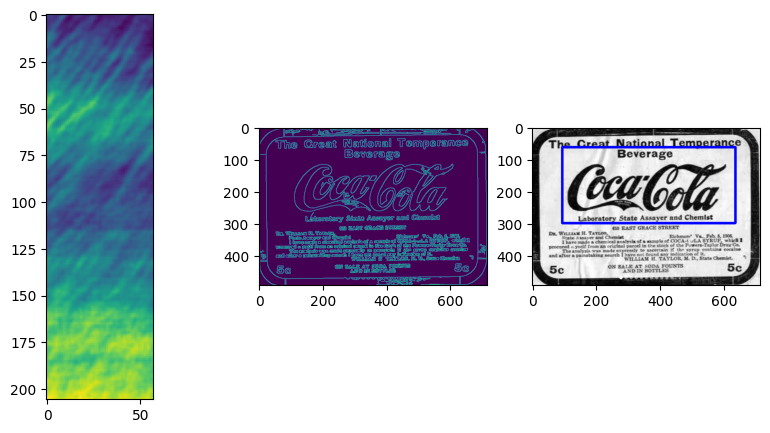

Imagen:  logo_1.png


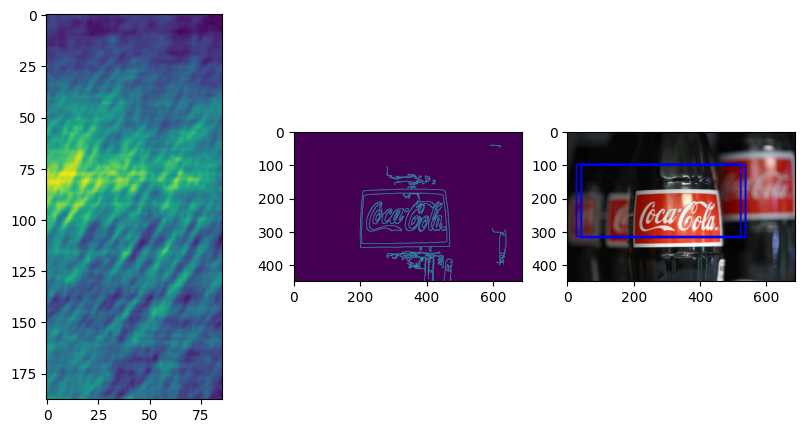

Imagen:  coca_logo_2.png


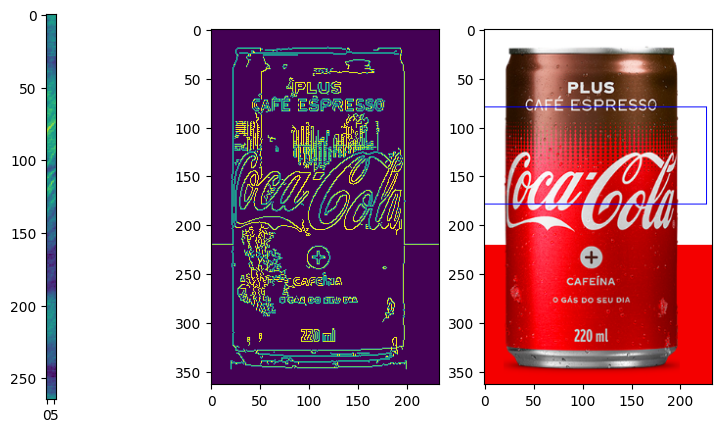

Imagen:  coca_retro_2.png


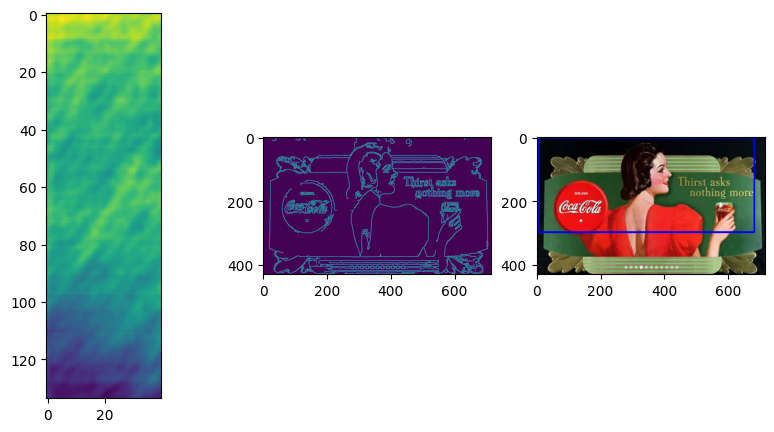

In [8]:
import numpy as np

metodo = cv.TM_CCOEFF
for img, filename in cargar_imagenes_desde_carpeta(IMG_DIR):
  print('Imagen: ', filename)

  temp = template_edges.copy()
  w, h = temp.shape[::-1]

  *_, img_w, img_h = img.shape[::-1]

  # Obtenemos los bordes con canny
  img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img_gray = cv.Canny(img_gray, threshold1=5, threshold2=250)

  # Utilizamos el ratio entre la imagen y template para mejorar
  # la ponderación de la escala
  ratio_w = (img_w/w)
  ratio_h = (img_h /h)
  ratio = max(ratio_w, ratio_h) /3

  # Probamos rescalar el template en 10 tamaños distintos dependientes del ratio
  mejor_puntaje = {}
  for scale in np.linspace(.2*ratio, 3*ratio, 10):
    # Recuperamos en cada iteración el tamaño original para el rescalado
    temp = cv.resize(template_edges.copy(), None, fx=scale, fy=scale)
    w, h = temp.shape[::-1]

    # Evitamos que tamaños muy grandes de template contaminen los resultados
    if w>img_w or h>img_h:
      continue

    # Matcheamos
    res = cv.matchTemplate(img_gray, temp, metodo)

    # Obtenemos el mejor puntaje y sus datos para utilizarlos más tarde
    if metodo in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
      puntaje = np.min(res)
      if 'puntaje' not in mejor_puntaje or puntaje < mejor_puntaje['puntaje']:
        mejor_puntaje['scale']=scale
        mejor_puntaje['puntaje']=puntaje
        mejor_puntaje['res']=res
    else:
      puntaje = np.max(res)
      if 'puntaje' not in mejor_puntaje or puntaje > mejor_puntaje['puntaje']:
        mejor_puntaje['scale']=scale
        mejor_puntaje['puntaje']=puntaje
        mejor_puntaje['res']=res

  if 'puntaje' not in mejor_puntaje:
    print('Salteando imagen -- Ninguna escala permitió un template suficientemente chico.')
    continue

  # Seteo el threshod dinámicamente para capturar una parte de los mejores resultados
  mult = .03
  # Estos métodos manejan números más lejanos entre sí
  if metodo in [cv.TM_CCOEFF_NORMED, cv.TM_CCORR_NORMED, cv.TM_SQDIFF_NORMED]:
    mult *= 8

  if metodo in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
    threshold = mejor_puntaje['puntaje'] * (1 + mult)
    loc = np.where(mejor_puntaje['res'] <= threshold)
  else:
    threshold = mejor_puntaje['puntaje'] * (1 - mult)
    loc = np.where(mejor_puntaje['res'] >= threshold)

  # Restauramos el tamaño para dibujar los rectángulos
  temp = cv.resize(template_edges.copy(), None, fx=mejor_puntaje['scale'], fy=mejor_puntaje['scale'])
  w, h = temp.shape[::-1]

  # Definimos el stroke con ayuda de las dimensiones para que 
  # se note bien en cualquier resolución
  for top_left in zip(*loc[::-1]):
    bottom_right = (top_left[0] + w, top_left[1] + h)
    rect_width = int(img_w* img_h ** .5) // 3000
    cv.rectangle(img_rgb, top_left, bottom_right, (0, 0, 255), rect_width)


  # Mostramos las imágenes
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 3, 1)
  plt.imshow(res)

  plt.subplot(1, 3, 2)
  plt.imshow(img_gray)

  plt.subplot(1, 3, 3)
  plt.imshow(img_rgb)
  
  plt.show()